In [37]:
#import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score,ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Read the data
data=pd.read_csv('online_shoppers_intention.csv')
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## **Data Preprocessing** ##

In [5]:
#checking rows and columns
data.shape

(12330, 18)

In [6]:
#checking for null values
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [7]:
#checking the data types
data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [8]:
# Step 1: Clean month names and map them correctly
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

# Optional: Handle non-standard/missing values
data['Month'] = data['Month'].map(month_map)

# Step 2: Drop rows where month mapping failed (if any)
data = data.dropna(subset=['Month'])  # or fillna if you prefer
data['Month'] = data['Month'].astype(int)

# Step 3: Now safely apply cyclical encoding
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

# Step 4: Drop original Month column
data.drop(columns='Month', inplace=True)


In [9]:
#encoding categorical columns
cat_cols = ['OperatingSystems', 'Browser', 'Region', 'TrafficType']
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)


In [10]:
# Keep original categories but drop one dummy to avoid collinearity
visitor_dummies = pd.get_dummies(
    data['VisitorType'],          
    prefix='Visitor',             
    drop_first=True               
)

data = pd.concat([data.drop(columns='VisitorType'), visitor_dummies], axis=1)


In [11]:
#convert boolean columns to integers
data['Weekend'] = data['Weekend'].astype('int8')
data['Revenue'] = data['Revenue'].astype('int8')

In [12]:
data.head(10)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,Visitor_Other,Visitor_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,...,False,False,False,False,False,False,False,False,False,True
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,...,False,False,False,False,False,False,False,False,False,True
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,...,False,False,False,False,False,False,False,False,False,True


In [13]:
print(data['Revenue'].value_counts(normalize=True))

Revenue
0    0.845255
1    0.154745
Name: proportion, dtype: float64


In [14]:
#analyzing skewed columns
skew_cols = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'PageValues'
]
data[skew_cols].describe(percentiles=[.95,.99,.995])


,Administrative_Duration,Informational_Duration,ProductRelated_Duration,PageValues
count,12330.000000,12330.000000,12330.000000,12330.000000
mean,80.818611,34.472398,1194.746220,5.889258
std,176.779107,140.749294,1913.669288,18.568437
min,0.000000,0.000000,0.000000,0.000000
50%,7.500000,0.000000,598.936905,0.000000
95%,348.266369,195.000000,4300.289077,38.160528
99%,830.587041,716.390000,8701.142697,85.498490
99.5%,1174.343000,1005.142000,11242.807460,110.391864
max,3398.750000,2549.375000,63973.522230,361.763742


In [15]:
#applying logarithmic Transformation
for col in skew_cols:
    data[col] = np.log1p(data[col])
data[skew_cols].describe(percentiles=[.95,.99,.995])

,Administrative_Duration,Informational_Duration,ProductRelated_Duration,PageValues
count,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.306655,0.844331,5.962529,0.624125
std,2.364922,1.816394,2.043091,1.267818
min,0.000000,0.000000,0.000000,0.000000
50%,2.140066,0.000000,6.396824,0.000000
95%,5.855834,5.278115,8.366669,3.667669
99%,6.723334,6.575603,9.071325,4.460116
99.5%,7.069312,6.913878,9.327573,4.713038
max,8.131457,7.843996,11.066240,5.893752


In [16]:
#applying Standardization
scaled_cols = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration',
    'PageValues'
]
base_numeric = [
    'Administrative', 'Informational', 'ProductRelated',
    'BounceRates', 'ExitRates', 'SpecialDay'
]
numeric_cols = base_numeric + scaled_cols
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
data[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,-2.996612e-17,1.000041,-0.696993,-0.696993,-0.395938,0.507228,7.431499
Informational,12330.0,-4.610172e-18,1.000041,-0.396478,-0.396478,-0.396478,-0.396478,18.499599
ProductRelated,12330.0,4.610172e-17,1.000041,-0.713488,-0.556092,-0.308755,0.140949,15.138577
BounceRates,12330.0,-6.454241e-17,1.000041,-0.457683,-0.457683,-0.393490,-0.110935,3.667189
ExitRates,12330.0,3.688137e-17,1.000041,-0.886371,-0.592393,-0.368691,0.142551,3.229316
SpecialDay,12330.0,-5.532206e-17,1.000041,-0.308821,-0.308821,-0.308821,-0.308821,4.718598
Administrative_Duration,12330.0,2.305086e-18,1.000041,-0.975402,-0.975402,-0.070445,0.946946,2.463100
Informational_Duration,12330.0,-1.613560e-17,1.000041,-0.464858,-0.464858,-0.464858,-0.464858,3.853762
ProductRelated_Duration,12330.0,-1.290848e-16,1.000041,-2.918505,-0.362911,0.212576,0.649625,2.498135
PageValues,12330.0,-6.915258e-17,1.000041,-0.492303,-0.492303,-0.492303,-0.492303,4.156622


<Axes: xlabel='Revenue', ylabel='count'>

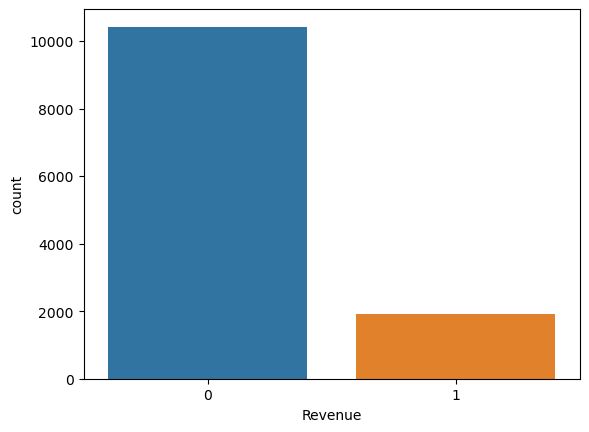

In [17]:
sns.countplot(x='Revenue',data=data)

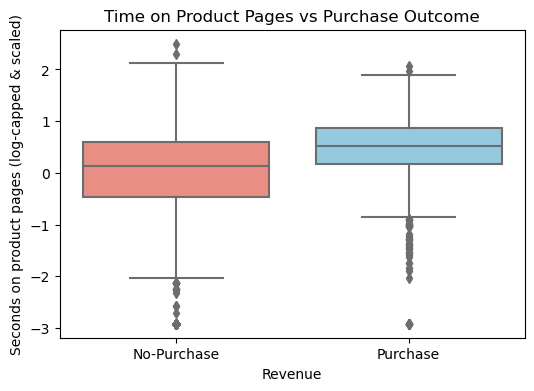

In [18]:
plt.figure(figsize=(6,4))
sns.boxplot(x='Revenue', y='ProductRelated_Duration', data=data,
            palette=['salmon','skyblue'])
plt.xticks([0,1], ['No-Purchase','Purchase'])
plt.ylabel('Seconds on product pages (log-capped & scaled)')
plt.title('Time on Product Pages vs Purchase Outcome')
plt.show()

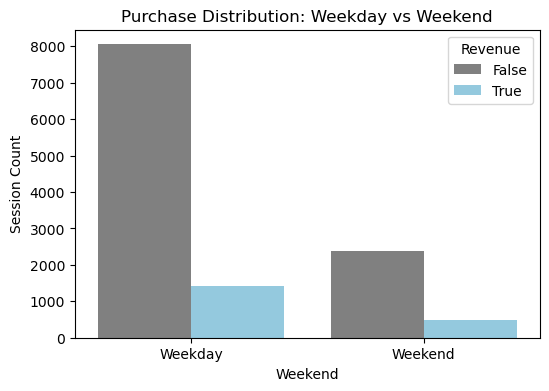

In [19]:
data2 = pd.read_csv('online_shoppers_intention.csv')

# Convert boolean to string
data2['Revenue'] = data2['Revenue'].astype(str)
data2['Weekend'] = data2['Weekend'].astype(str)

plt.figure(figsize=(6, 4))
sns.countplot(x='Weekend', hue='Revenue', data=data2, palette=['grey', 'skyblue'])
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.ylabel('Session Count')
plt.title("Purchase Distribution: Weekday vs Weekend")
plt.legend(title="Revenue")
plt.show()

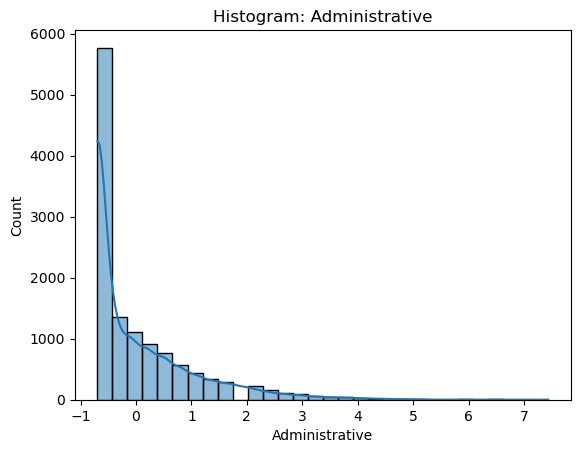

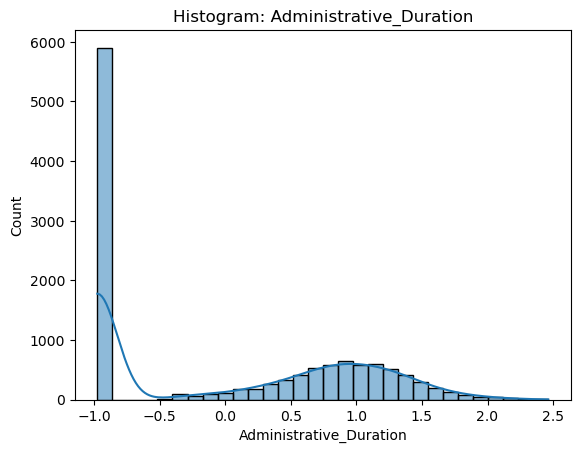

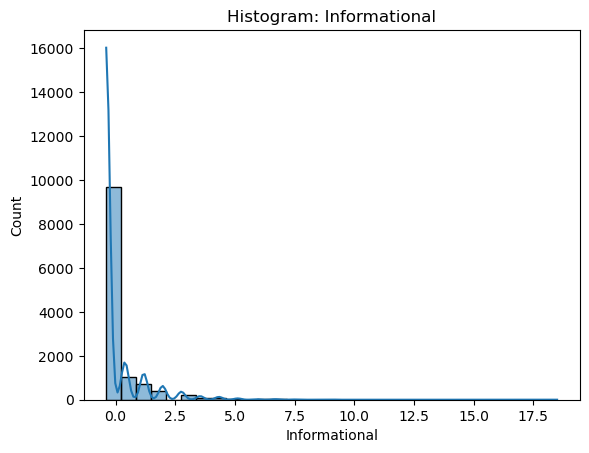

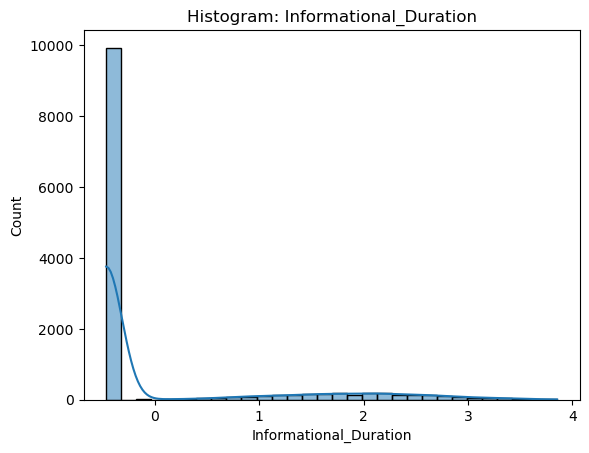

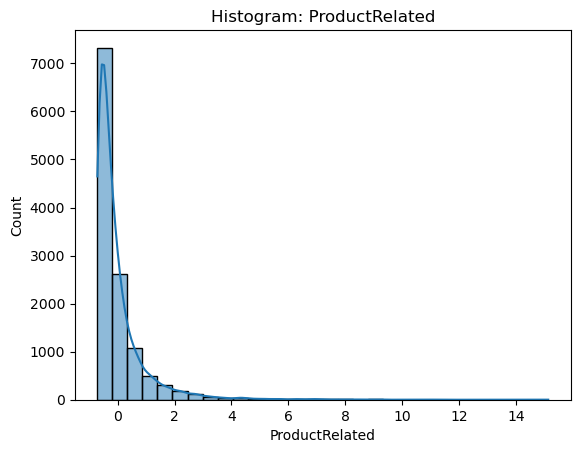

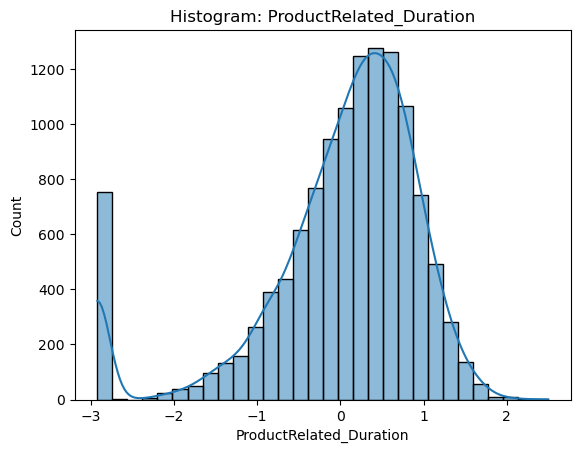

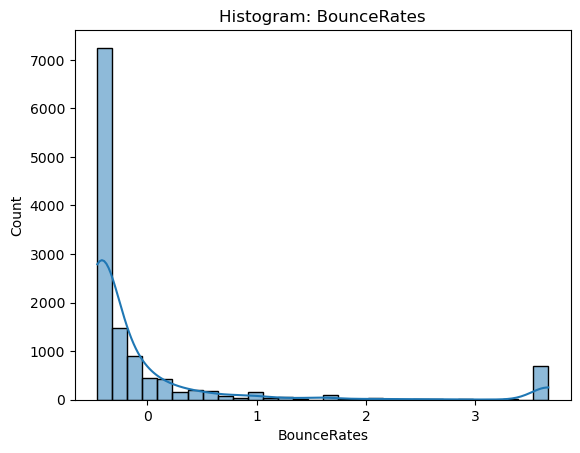

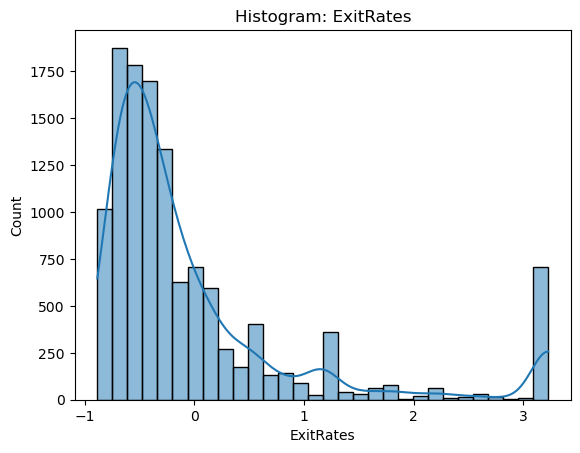

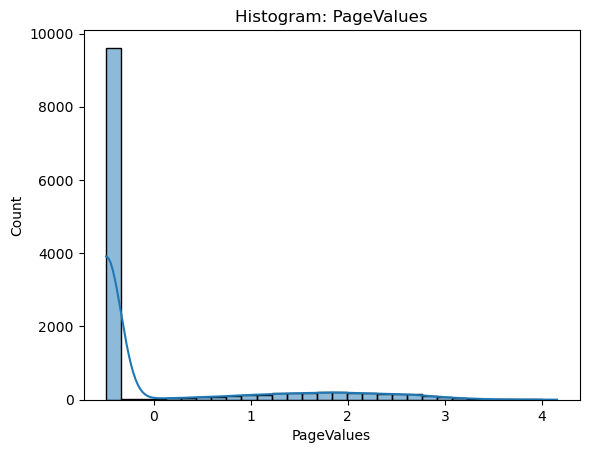

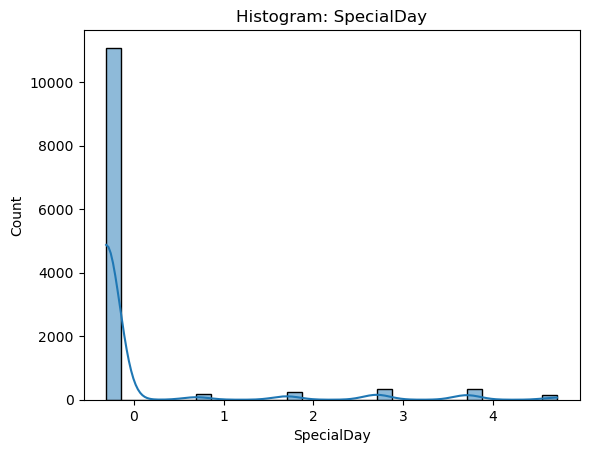

In [20]:
num_cols = ['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay']   
for col in num_cols:
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f"Histogram: {col}")
    plt.show()


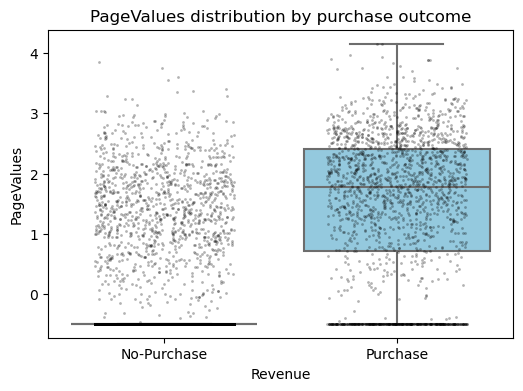

In [21]:
#visualizing pagevalues for each revenues
plt.figure(figsize=(6,4))
sns.boxplot(x='Revenue', y='PageValues', data=data,
            palette=['salmon','skyblue'], showfliers=False)
sns.stripplot(x='Revenue', y='PageValues', data=data,
              color='black', size=2, jitter=0.3, alpha=0.3)
plt.xticks([0,1], ['No-Purchase','Purchase'])
plt.ylabel('PageValues')
plt.title('PageValues distribution by purchase outcome')
plt.show()


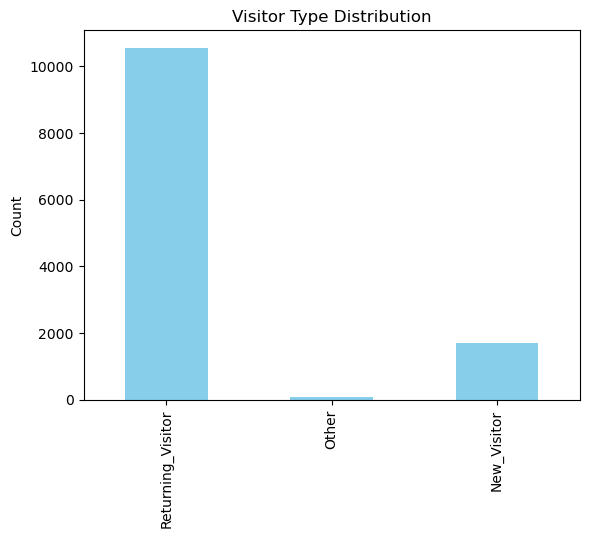

In [22]:
#visualizing count of different type of visitors
visitor_counts = pd.DataFrame({
    'Returning_Visitor': data['Visitor_Returning_Visitor'].sum(),
    'Other': data['Visitor_Other'].sum(),
    'New_Visitor': len(data) - data[['Visitor_Returning_Visitor', 'Visitor_Other']].sum().sum()
}, index=['Count']).T

visitor_counts.plot(kind='bar', legend=False, color='skyblue')
plt.title('Visitor Type Distribution')
plt.ylabel('Count')
plt.show()


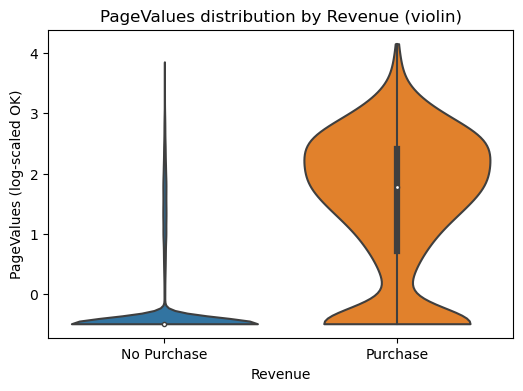

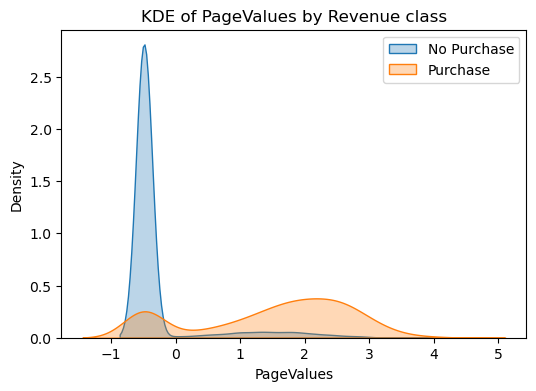

In [23]:
#Visualizing pagecounts for different revenues
plt.figure(figsize=(6,4))
sns.violinplot(x='Revenue',
               y='PageValues',
               data=data,
               cut=0,          # don’t extend tails beyond data range
               scale='width')  # equal area per class
plt.title("PageValues distribution by Revenue (violin)")
plt.xticks([0,1], ['No Purchase', 'Purchase'])
plt.ylabel("PageValues (log-scaled OK)")
plt.show()

# ── 2) Overlaid KDE curves ────────────────────────────────────
plt.figure(figsize=(6,4))
sns.kdeplot(data=data[data['Revenue']==0]['PageValues'],
            label='No Purchase', bw_adjust=1.2, fill=True, alpha=0.3)
sns.kdeplot(data=data[data['Revenue']==1]['PageValues'],
            label='Purchase', bw_adjust=1.2, fill=True, alpha=0.3)
plt.title("KDE of PageValues by Revenue class")
plt.xlabel("PageValues")
plt.legend()
plt.show()

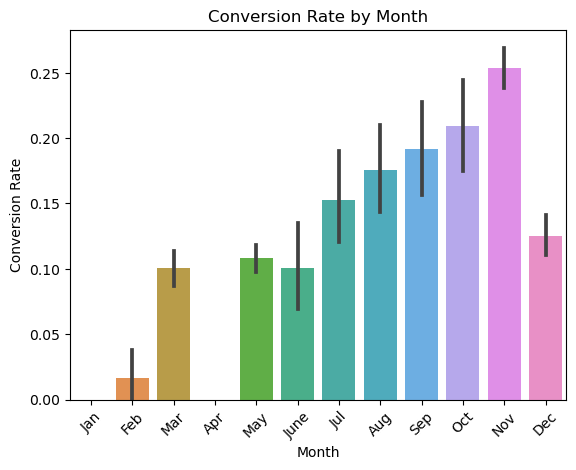

In [24]:
#Monthly revenue visualization
# Step 1: Load raw data
raw = pd.read_csv('online_shoppers_intention.csv')

# Step 2: Add Month back into current processed data
data['Month'] = raw['Month']

sns.barplot(x='Month', y='Revenue', data=data, estimator=lambda x: x.mean(), order=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.xticks(rotation=45)
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate by Month")
plt.show()

Text(0.5, 1.0, 'Correlation matrix')

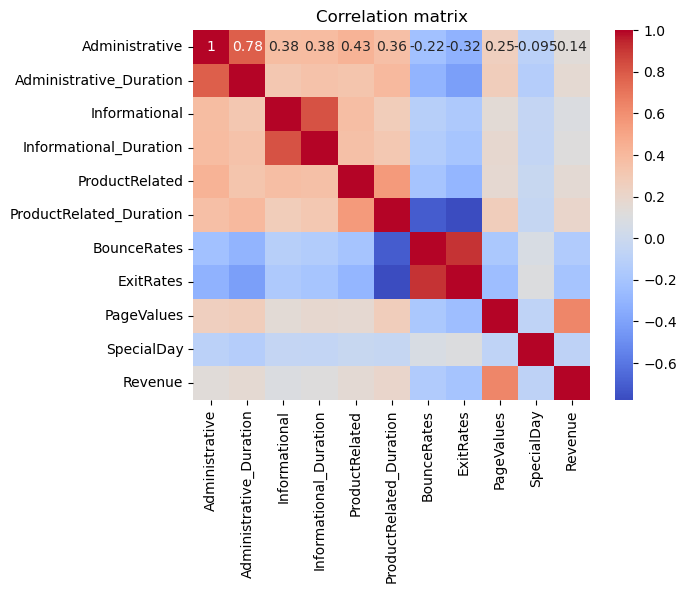

In [25]:
#Visualization of the correlation
corr = data[num_cols + ['Revenue']].corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title("Correlation matrix")


Text(0.5, 1.0, 'Bounce vs Exit Rates coloured by Revenue')

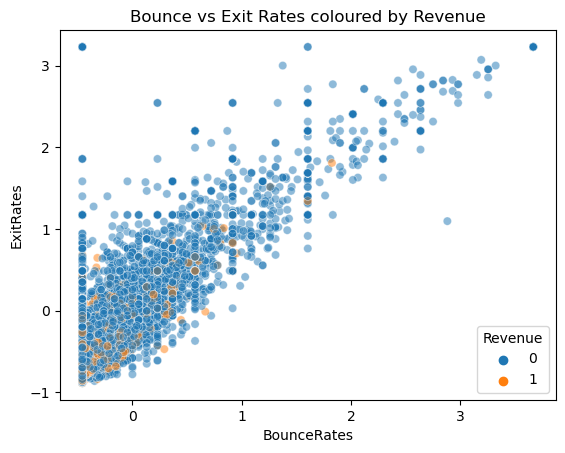

In [26]:
sns.scatterplot(x='BounceRates', y='ExitRates',
                hue='Revenue', data=data, alpha=0.5)
plt.title("Bounce vs Exit Rates coloured by Revenue")


## **Clustering** ##

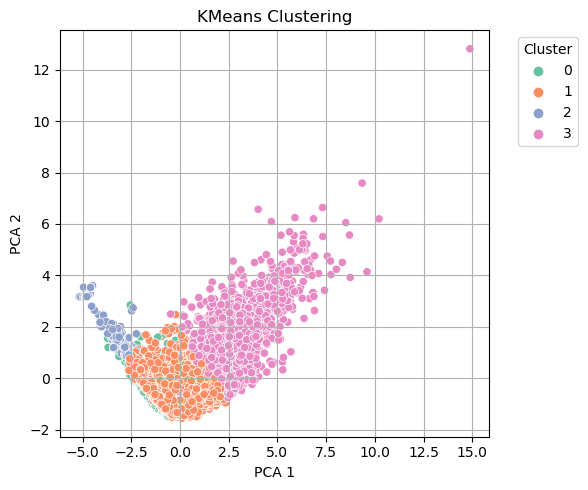

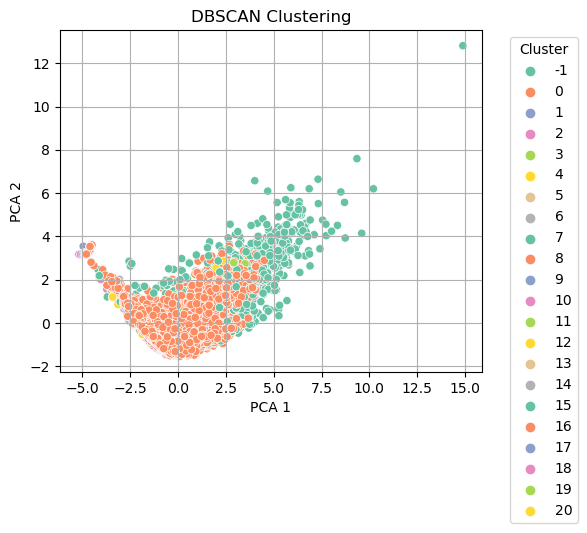

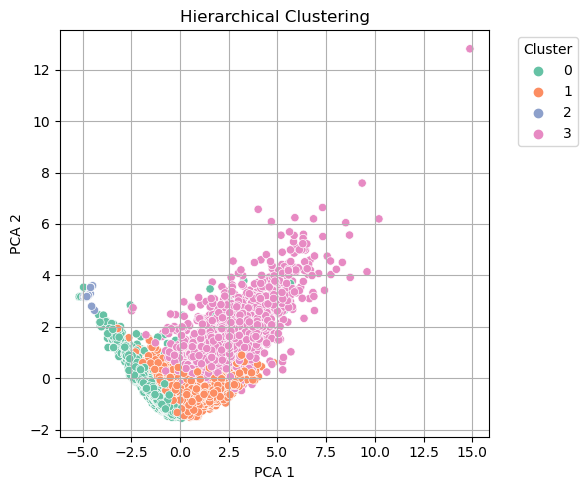

In [27]:
numeric_cols = [
    'Administrative', 'Informational', 'ProductRelated',
    'BounceRates', 'ExitRates', 'SpecialDay',
    'Administrative_Duration', 'Informational_Duration',
    'ProductRelated_Duration', 'PageValues'
]
# Use your standardized features
X = data[numeric_cols]

#  reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(X)

# DBSCAN
dbscan = DBSCAN(eps=1.0, min_samples=5)
data['DBSCAN_Cluster'] = dbscan.fit_predict(X)

# Hierarchical Clustering
agg = AgglomerativeClustering(n_clusters=4)
data['Hierarchical_Cluster'] = agg.fit_predict(X)

# Plotting function
def plot_cluster(xy, labels, title):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue=labels, palette='Set2')
    plt.title(title)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(title="Cluster", loc='best', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Visualize clustering results
plot_cluster(X_pca, data['KMeans_Cluster'], "KMeans Clustering")
plot_cluster(X_pca, data['DBSCAN_Cluster'], "DBSCAN Clustering")
plot_cluster(X_pca, data['Hierarchical_Cluster'], "Hierarchical Clustering")

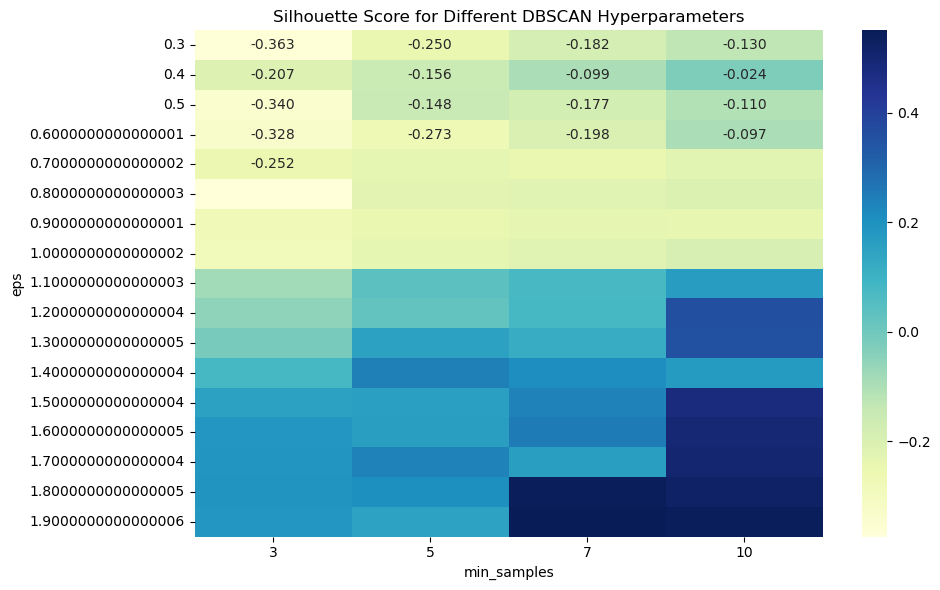

In [28]:
# Step 1: Use your scaled data
X = data[numeric_cols]

# Step 2: Try different eps and min_samples
eps_values = np.arange(0.3, 2.0, 0.1)
min_samples_values = [3, 5, 7, 10]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Ignore models that classify everything as noise
        if len(set(labels)) > 1 and -1 in labels:
            try:
                sil_score = silhouette_score(X, labels)
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                n_noise = list(labels).count(-1)
                results.append((eps, min_samples, sil_score, n_clusters, n_noise))
            except:
                continue

# Step 3: Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette_score', 'n_clusters', 'n_noise'])

# Step 4: Plot Silhouette Scores
pivot = results_df.pivot(index='eps', columns='min_samples', values='silhouette_score')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('Silhouette Score for Different DBSCAN Hyperparameters')
plt.ylabel('eps')
plt.xlabel('min_samples')
plt.tight_layout()
plt.show()

In [29]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
data['DBSCAN_Optimized'] = dbscan.fit_predict(data[numeric_cols])


In [30]:
def generate_cluster_profile(data, cluster_col, features_to_summarize):
    
    # Compute means
    profile_means = data.groupby(cluster_col)[features_to_summarize].mean().round(2)
    
    # Compute cluster sizes
    cluster_counts = data[cluster_col].value_counts().sort_index()
    profile_means['Count'] = cluster_counts.values  # Add cluster sizes
    
    return profile_means.reset_index()

In [31]:
### Select features to analyze
features = [
    'Administrative', 'Informational', 'ProductRelated',
    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'
]

# Generate cluster profiles
kmeans_profile = generate_cluster_profile(data, 'KMeans_Cluster', features)
dbscan_profile = generate_cluster_profile(data, 'DBSCAN_Optimized', features)
hierarchical_profile = generate_cluster_profile(data, 'Hierarchical_Cluster', features)


print("KMeans Cluster Profile with Counts:")
print(kmeans_profile)


KMeans Cluster Profile with Counts:
   KMeans_Cluster  Administrative  Informational  ProductRelated  BounceRates  \
0               0           -0.41          -0.27           -0.12        -0.01   
1               1           -0.18          -0.33           -0.18        -0.27   
2               2           -0.69          -0.39           -0.67         3.26   
3               3            1.16           1.53            1.02        -0.32   

   ExitRates  PageValues  SpecialDay  Count  
0       0.14       -0.28        3.16    905  
1      -0.22       -0.05       -0.29   8344  
2       3.01       -0.49        0.03    897  
3      -0.47        0.51       -0.22   2184  


In [32]:
print("DBSCAN Cluster profile with Counts:")
print(dbscan_profile)

DBSCAN Cluster profile with Counts:
   DBSCAN_Optimized  Administrative  Informational  ProductRelated  \
0                -1            1.87           2.92            3.13   
1                 0           -0.03          -0.05           -0.06   
2                 1           -0.70          -0.40           -0.69   
3                 2            0.08           0.73            0.54   
4                 3            0.71           1.70            7.55   

   BounceRates  ExitRates  PageValues  SpecialDay  Count  
0        -0.21      -0.31        0.49        0.96    207  
1         0.00       0.00       -0.01       -0.02  12106  
2        -0.46       3.23       -0.49       -0.17      7  
3        -0.26      -0.41        1.36        3.43      7  
4        -0.35      -0.49       -0.49       -0.31      3  


In [33]:
print("Hierarchical Cluster profile with Counts:")
print(hierarchical_profile)

Hierarchical Cluster profile with Counts:
   Hierarchical_Cluster  Administrative  Informational  ProductRelated  \
0                     0           -0.60          -0.34           -0.31   
1                     1            0.33          -0.37            0.04   
2                     2           -0.69          -0.39           -0.68   
3                     3            0.78           1.58            0.78   

   BounceRates  ExitRates  PageValues  SpecialDay  Count  
0        -0.04       0.18       -0.44        0.47   4737  
1        -0.32      -0.42        0.34       -0.30   4671  
2         3.67       3.23       -0.49       -0.24    654  
3        -0.31      -0.43        0.35       -0.29   2268  


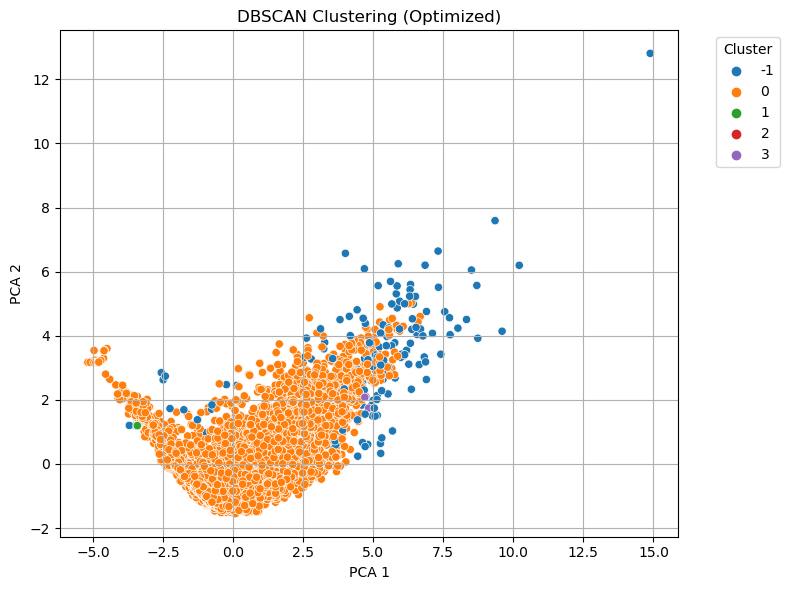

In [34]:
X = data[numeric_cols]

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the optimized DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=data['DBSCAN_Optimized'],
    palette='tab10',
    legend='full'
)
plt.title('DBSCAN Clustering (Optimized)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Bounce vs Exit Rates coloured by Revenue')

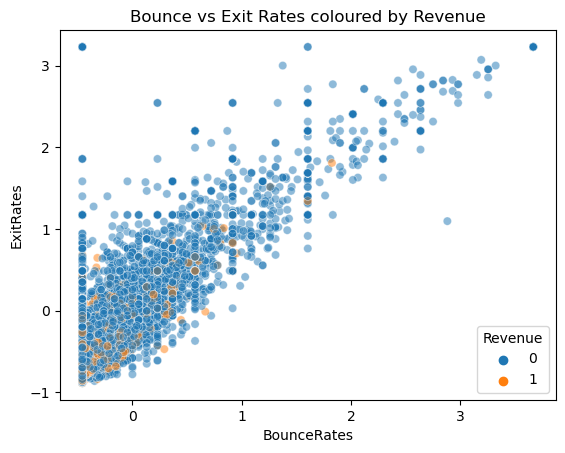

In [35]:
sns.scatterplot(x='BounceRates', y='ExitRates',
                hue='Revenue', data=data, alpha=0.5)
plt.title("Bounce vs Exit Rates coloured by Revenue")


In [38]:
# train and test splitting
X = data.drop(columns=['Month','Revenue'])
y = data['Revenue']
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [39]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}
results = []

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # For ROC AUC
    
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)
    
    results.append({
        "Model": name,
        "Accuracy":accuracy_score(y_test, y_pred),
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1-Score": report['1']['f1-score'],
        "ROC AUC": auc
    })

pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
1,Random Forest,0.889294,0.630695,0.688482,0.658323,0.920243
5,Gradient Boosting,0.877534,0.580321,0.756545,0.656818,0.925950
4,Support Vector Machine,0.869830,0.559687,0.748691,0.640538,0.897606
0,Logistic Regression,0.860503,0.538934,0.688482,0.604598,0.879256
3,K-Nearest Neighbors,0.845093,0.500000,0.732984,0.594480,0.861648
2,Decision Tree,0.850365,0.513684,0.638743,0.569428,0.763949


In [43]:
param_grid = {
    'n_estimators': [100, 200],            # number of trees
    'learning_rate': [0.05, 0.1, 0.2],     # how much each tree contributes
    'max_depth': [3, 4, 5],                # how deep each tree can grow
    'min_samples_split': [2, 5]            # minimum samples to split a node
}


In [44]:
gbc = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    scoring='f1',        # Optimize for F1 score
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,           # Use all CPU cores
    verbose=2
)

grid_search.fit(X_train_balanced, y_train_balanced)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=2)

In [45]:
best_model = grid_search.best_estimator_
print("Best Parameters Found:", grid_search.best_params_)


Best Parameters Found: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}


In [46]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2084
           1       0.61      0.67      0.64       382

    accuracy                           0.88      2466
   macro avg       0.77      0.80      0.78      2466
weighted avg       0.89      0.88      0.88      2466

ROC AUC: 0.9175983057149462
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=2, n_estimators=200; total time=  18.9s
[CV] END learning_rate=0.05, max_depth=3, min_samples_split=5, n_estimators=200; total time=  23.1s
[CV] END learning_rate=0.05, max_depth=4, min_samples_split=2, n_estimators=200; total time=  32.5s
[CV] END learning_rate=0.05, max_depth=4, min_samples_split=5, n_estimators=200; total time=  34.3s
[CV] END learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=200; total time=  42.8s
[CV] END learning_rate=0.05, max_depth=5, min_samples_split=5, n_estimators=200; total time=  45.9s
[CV] END learning_rate=0.1, max_depth=3, min_

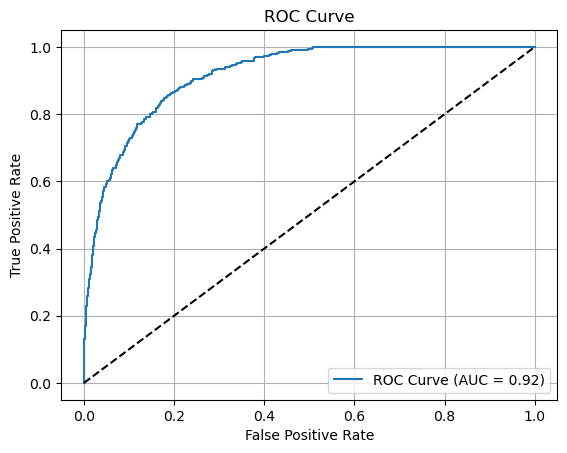

In [49]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [51]:
rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,               # Number of combinations to try
    cv=5,                    # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='f1'
)

random_search.fit(X_train_balanced, y_train_balanced)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='f1', verbose=2)

[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   8.9s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  20.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  12.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  13.1s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  21.8s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  10.6s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time=  27.7s
[CV] END bootstrap=True, max_depth=None

In [52]:
best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("Best Parameters:", random_search.best_params_)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2084
           1       0.64      0.68      0.66       382

    accuracy                           0.89      2466
   macro avg       0.79      0.80      0.80      2466
weighted avg       0.89      0.89      0.89      2466

ROC AUC: 0.9173219543568049


,Model,Version,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Random Forest,Before,0.889,0.631,0.688,0.658,0.920
1,Random Forest,After,0.890,0.640,0.680,0.660,0.917
2,Gradient Boosting,Before,0.878,0.580,0.757,0.657,0.926
3,Gradient Boosting,After,0.880,0.610,0.670,0.640,0.918


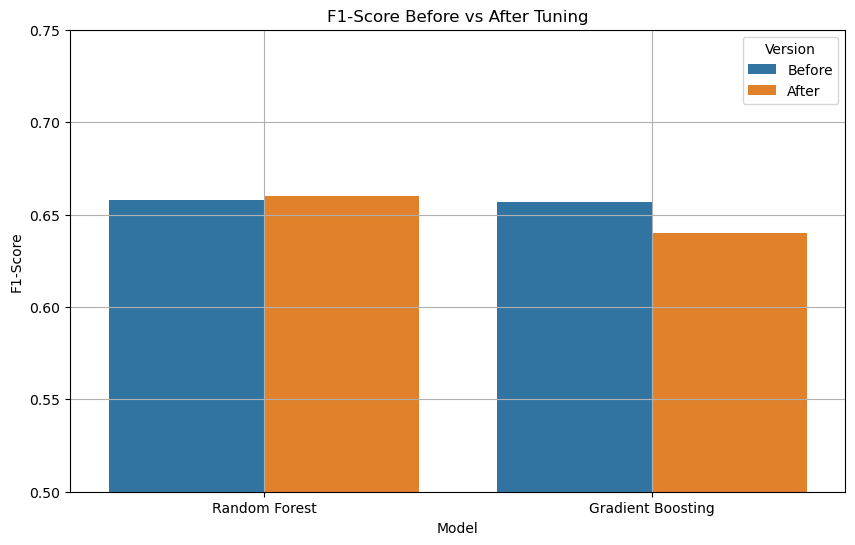

In [53]:
comparison_data = [
    ["Random Forest", "Before", 0.889, 0.631, 0.688, 0.658, 0.920],
    ["Random Forest", "After",  0.890, 0.640, 0.680, 0.660, 0.917],
    ["Gradient Boosting", "Before", 0.878, 0.580, 0.757, 0.657, 0.926],
    ["Gradient Boosting", "After",  0.880, 0.610, 0.670, 0.640, 0.918]
]

columns = ["Model", "Version", "Accuracy", "Precision", "Recall", "F1-Score", "ROC AUC"]
comparison_df = pd.DataFrame(comparison_data, columns=columns)
display(comparison_df)

plt.figure(figsize=(10,6))
sns.barplot(data=comparison_df, x="Model", y="F1-Score", hue="Version")
plt.title("F1-Score Before vs After Tuning")
plt.ylim(0.5, 0.75)
plt.grid(True)
plt.show()

,Model,Version,Recall
0,Random Forest,Before,0.688
1,Random Forest,After,0.680
2,Gradient Boosting,Before,0.757
3,Gradient Boosting,After,0.670


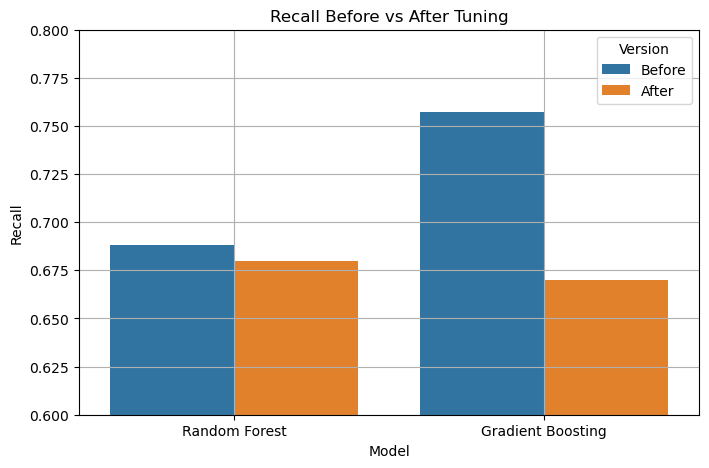

In [55]:
recall_data = [
    ["Random Forest", "Before", 0.688],
    ["Random Forest", "After",  0.680],
    ["Gradient Boosting", "Before", 0.757],
    ["Gradient Boosting", "After",  0.670]
]

recall_df = pd.DataFrame(recall_data, columns=["Model", "Version", "Recall"])
display(recall_df)

plt.figure(figsize=(8, 5))
sns.barplot(data=recall_df, x="Model", y="Recall", hue="Version")
plt.title("Recall Before vs After Tuning")
plt.ylim(0.6, 0.8)
plt.grid(True)
plt.show()
